# Аналитика маркетплейса

Вы — аналитик данных, и сейчас идёте в стартап, который создает новый маркетплейс. Он недавно появился на рынке и занимается продажей новых товаров из Бразилии, которые только начинают поступать в продажу.

Продакт-менеджер Петя переживает за свой продукт, так как выручка маркетплейса стоит на месте уже несколько месяцев. Он предложил вам полную свободу действий. Главное — чтобы метрики росли, а мы не причиняли неудобства клиентам, ведь Петя заботится об их опыте.

## Задачи проекта

- Задача 1: Оценить месячный retention в оформление заказа с помощью когортного анализа.
- Задача 2: Определить, существует ли product/market fit у этого маркетплейса.
- Задача 3: Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.
- Задача 4: Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.
- Задача 5: Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.
- Задача 6: Сформулировать выводы о проделанной работе. 

## Описание данных

Датасет
Файлы:

 **olist_customers_dataset.csv** — таблица с уникальными идентификаторами пользователей
 
`customer_id` — позаказный идентификатор пользователя

`customer_unique_id` — уникальный идентификатор пользователя (аналог номера паспорта)

`customer_zip_code_prefix` — почтовый индекс пользователя

`customer_city` — город доставки пользователя

`customer_state` — штат доставки пользователя

**olist_orders_dataset.csv** —  таблица заказов

`order_id` — уникальный идентификатор заказа (номер чека)

`customer_id` — позаказный идентификатор пользователя

`order_status` — статус заказа

`order_purchase_timestamp` — время создания заказа

`order_approved_at` — время подтверждения оплаты заказа

`order_delivered_carrier_date` — время передачи заказа в логистическую службу

`order_delivered_customer_date` — время доставки заказа

`order_estimated_delivery_date` — обещанная дата доставки

**olist_order_items_dataset.csv** — товарные позиции, входящие в заказы

`order_id` — уникальный идентификатор заказа (номер чека)

`order_item_id` — идентификатор товара внутри одного заказа

`product_id` — ид товара (аналог штрихкода)

`seller_id` — ид производителя товара

`shipping_limit_date` — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

`price` — цена за единицу товара

`freight_value` — вес товара

Уникальные статусы заказов в таблице **olist_orders_dataset**:

- created — создан;
- approved — подтверждён;
- invoiced — выставлен счёт;
- processing — в процессе сборки заказа;
- shipped — отгружён со склада;
- delivered — доставлен пользователю;
- unavailable — заказ отменён по причине недоступности товара;;
- canceled — отменён.

### Загрузка данных

In [74]:
import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from operator import attrgetter

In [75]:
# Загружаем датасеты по ссылке на яндекс диске
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Ссылки на наши датасеты на яндекс диске
public_key1 = 'https://yadi.sk/d/QXrVDUoQvFhIcg' 
public_key2 = 'https://yadi.sk/d/0zWmh1bYP6REbw'
public_key3 = 'https://yadi.sk/d/xCsQ0FiC-Ue4Lg'

# Получаем загрузочные ссылки
final_url1 = base_url + urlencode(dict(public_key = public_key1))
final_url2 = base_url + urlencode(dict(public_key = public_key2))
final_url3 = base_url + urlencode(dict(public_key = public_key3))

response1 = requests.get(final_url1)
response2 = requests.get(final_url2)
response3 = requests.get(final_url3)

download_url1 = response1.json()['href']
download_url2 = response2.json()['href']
download_url3 = response3.json()['href']

# Загружаем файлы в df 
download_response1 = requests.get(download_url1) 
download_response2 = requests.get(download_url2) 
download_response3 = requests.get(download_url3) 

customers   = pd.read_csv(download_url1, sep = ',') 
orders      = pd.read_csv(download_url2, sep = ',') 
order_items = pd.read_csv(download_url3, sep = ',') 

In [76]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [77]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [78]:
customers.describe(include = 'object')

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,bbac29c51bb48d544ffaa7485344f42b,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


`Customer_unique_id` - имеет не все уникальные поля. Возможно это задвоенние данных.

Выглядит именно так, что данные задвоились. Удалим их.

In [79]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [80]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [81]:
#изменяем тип данных у дат
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)

In [82]:
orders.describe(include = 'object')

,order_id,customer_id,order_status
count,99441,99441,99441
unique,99441,99441,8
top,56e434b038a40c8b9b03a9b9dcede8f9,bbac29c51bb48d544ffaa7485344f42b,delivered
freq,1,1,96478


In [83]:
orders.describe(include = "datetime")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence thi

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
unique,98875,90733,81018,95664,459
top,2018-03-31 15:08:21,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,3,9,47,3,522
first,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


In [84]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Пропущенные значения в полях:
1. `order_approved_at` — время подтверждения оплаты заказа.

2. `order_delivered_carrier_date` — время передачи заказа в логистическую службу

3. `order_delivered_customer_date` — время доставки заказа

Возможные причины: 
1. Заказ не оплачен.
2. Логистическая служба не оставила отметку о передачи заказа в доставку, или произошел сбой.

In [85]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [86]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [87]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [88]:
order_items.describe(include='object')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


### 1. Когортный анализ

In [89]:
orders['order_period'] = orders['order_purchase_timestamp'].dt.to_period('M')
orders['order_period_day'] = orders['order_purchase_timestamp'].dt.to_period('D')

In [90]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,2018-02-13


In [91]:
#оставим только те заказы, которые уже доставлены
success_orders = orders.query('order_status =="delivered"')
customers_and_orders = success_orders.merge(customers, on ='customer_id')

In [92]:
customers_and_orders['cohort'] = customers_and_orders.groupby('customer_unique_id')['order_purchase_timestamp']\
                                                     .transform('min').dt.to_period('M')
customers_and_orders['cohort_day'] = customers_and_orders.groupby('customer_unique_id')['order_purchase_timestamp']\
                                                     .transform('min').dt.to_period('D')

In [93]:
customers_and_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,cohort,cohort_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09,2017-09-04
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,2018-07-24,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,2018-08-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,2017-11-18,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,2018-02-13,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,2018-02-13


In [94]:
customers_and_orders['period_number_month'] = np.floor((customers_and_orders.order_period_day - customers_and_orders.cohort_day)\
                                                       .apply(attrgetter('n'))/30)

In [95]:
df_cohort = customers_and_orders.groupby(['cohort','period_number_month']).agg(n_customers=('customer_unique_id', 'nunique'))\
                                            .reset_index()
df_cohort

,cohort,period_number_month,n_customers
0,2016-09,0.0,1
1,2016-10,0.0,262
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1
...,...,...,...
210,2018-06,1.0,22
211,2018-06,2.0,6
212,2018-07,0.0,5949
213,2018-07,1.0,6


In [96]:
cohort_pivot = df_cohort.pivot_table(values='n_customers', columns='period_number_month', index='cohort')
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
cohort_size = cohort_pivot.iloc[:, 0]
cohort_size.median()

4057.0

In [98]:
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN
2017-03,1.0,0.002797,0.005194,0.004395,0.001199,0.000799,0.003596,0.001598,0.002397,0.002397,...,0.001598,0.001598,0.001199,0.002797,0.000799,0.001199,0.000799,NaN,NaN,NaN
2017-04,1.0,0.003546,0.002660,0.000443,0.002660,0.003546,0.002660,0.004433,0.002216,0.002660,...,0.001330,NaN,0.000887,0.000887,0.000887,0.000887,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002318,0.003767,0.003187,0.003187,0.001159,0.002898,0.002608,...,0.003187,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004281,0.004939,0.003622,0.001646,0.005268,0.002963,0.001976,0.001317,0.003293,...,0.002963,0.000988,0.002963,0.001317,NaN,NaN,NaN,NaN,NaN,NaN


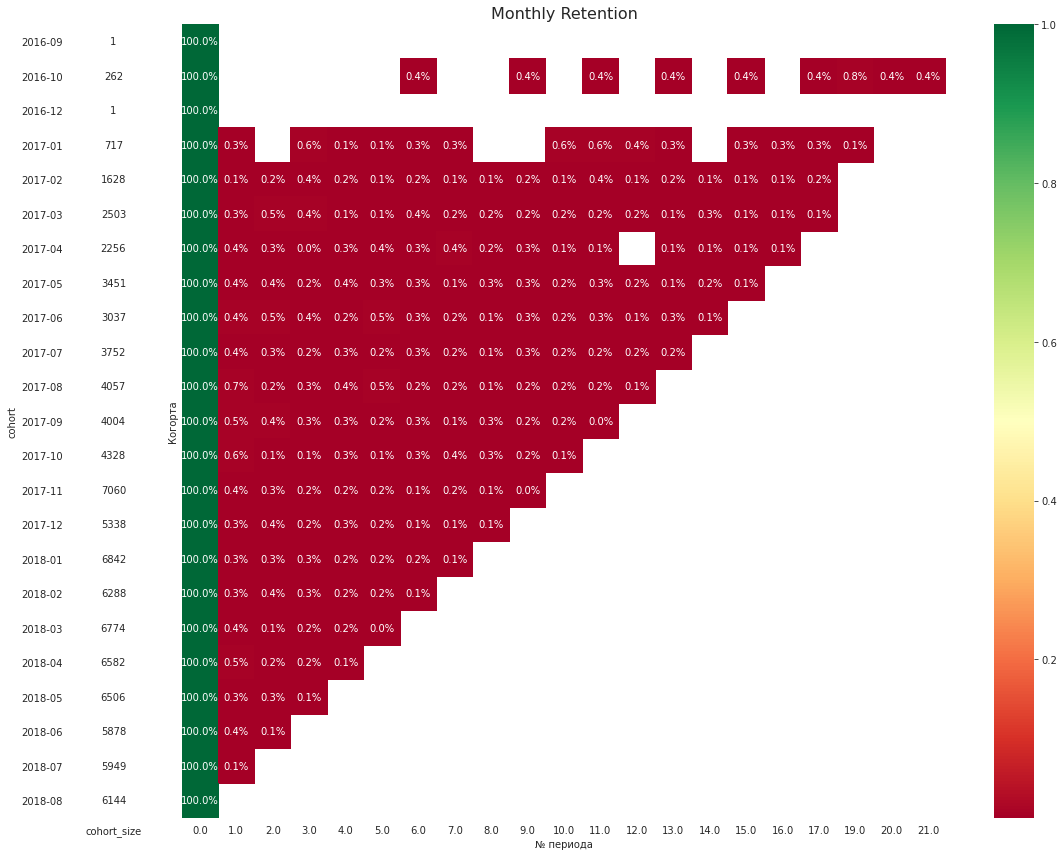

In [99]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    #тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
               mask=retention_matrix.isnull(),
               annot=True,
               fmt='.1%',
               cmap='RdYlGn',
               ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize = 16)
    ax[1].set(xlabel = '№ периода', ylabel= 'Когорта')
    
    #тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
               annot = True, 
               cbar=False,
               fmt = 'g',
               cmap=white_cmap,
               ax=ax[0])
    
    fig.tight_layout()
    plt.show()

In [100]:
print(f"Медианный retention 1-ого месяца: {round(retention_matrix[1].median(), 4)}")

Медианный retention 1-ого месяца: 0.0035


In [101]:
print(f"Когорта с самым высоким retention на 3-й месяц: {retention_matrix[3.0].idxmax()}")

Когорта с самым высоким retention на 3-й месяц: 2017-01


### 2. Product/market fit маркетплейса.

На основе когортного анализа *Product/market fit* **отсутствует**. Низкий retention, стремящийся к нулю показывает, что наш продукт не удовлетворяет потребностям рынка. Клиенты практически не возвращаются, сделав первый заказ. Но! Видна хорошая привлекаемость клиентов - **количество новых клиентов увеличивается**. Для повышения уровня удержания пользователя и улучшения ситуации в целом стоит совершить следующие шаги:

- Стоит посмотреть на воронку конверсий пользователя в приложении, на каком этапе пользователи отваливаются. Возможно функционал приложения слишком сложный; 
- Возможно пользователям не нравятся сроки доставки, стоит рассмотреть другие логистические компании. Процент заказов, которые пришли позже прогнозируемого срока доставки около 8%;
- Провести анализ качества продукта;
- Анализ конкурентов, какие функции они предлагают? Какие у них сильные стороны?
- Улучшить стратегию маркетинга: использовать контекстную рекламу, SEO, социальные сети;
- Провести опрос пользователей, и провести анализ на основе этого. Определить своих самых активных и лояльных пользователей, почему они используют продукт;
- Тестирование гипотез на основе фреймворка ICE и проведение AB тестов на внедрение новых фичей или исправлении багов;


In [102]:
delay_orders = ((orders.query('order_status == "delivered"').order_delivered_customer_date
                 - orders.query('order_status == "delivered"').order_estimated_delivery_date)> '00:00:00').sum()
all_delivered_orders = orders.query('order_status == "delivered"').order_id.nunique()

In [103]:
print(f'Процент заказов, которые пришли позже прогнозируемого срока доставки: {(delay_orders/all_delivered_orders):.2%}')

Процент заказов, которые пришли позже прогнозируемого срока доставки: 8.11%


### 3 Основные метрики для максимизации прибыли компании

Первая метрика должна отражать рост объёма продаж маркетплейса.

Вторая — показывать объем аудитории, которой продукт доставляет ценность.

Третья — отражать заинтересованность новых клиентов в продакте.

Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.

Пятая — отражать денежное выражение вовлеченности клиента.

#### 3.1 Рост объема продаж маркетплейса.

In [104]:
order_items.groupby('order_id', as_index=False).agg(mean_price=('price','mean'), count_order_item=('order_item_id', 'count'),
                                                   count_product=('product_id', 'count'),
                                                   count_seller=('seller_id', 'count')).head()

,order_id,mean_price,count_order_item,count_product,count_seller
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,1,1,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,1,1,1
2,000229ec398224ef6ca0657da4fc703e,199.00,1,1,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,1,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,1,1


In [105]:
data = customers_and_orders.merge(order_items, on='order_id')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,...,customer_state,cohort,cohort_day,period_number_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10-02,...,SP,2017-09,2017-09-04,0.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,2018-07-24,...,BA,2018-07,2018-07-24,0.0,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,2018-08-08,...,GO,2018-08,2018-08-08,0.0,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,2017-11-18,...,RN,2017-11,2017-11-18,0.0,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,2018-02-13,...,SP,2018-02,2018-02-13,0.0,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [106]:
monthly_sales = data.groupby(['order_period'], as_index=False).agg(monthly_revenue=('price', 'sum'), 
                                                                   monthly_customers=('customer_unique_id', 'nunique'),
                                                                  count_orders =('order_id', 'count'))\
                                                .assign(cumul_monthly_sum=lambda x: x.monthly_revenue.cumsum())\
                                                                
monthly_sales

,order_period,monthly_revenue,monthly_customers,count_orders,cumul_monthly_sum
0,2016-09,134.97,1,3,134.97
1,2016-10,40325.11,262,313,40460.08
2,2016-12,10.90,1,1,40470.98
3,2017-01,111798.36,718,913,152269.34
4,2017-02,234223.40,1630,1858,386492.74
5,2017-03,359198.85,2508,2897,745691.59
6,2017-04,340669.68,2274,2569,1086361.27
7,2017-05,489338.25,3479,4004,1575699.52
8,2017-06,421923.37,3076,3489,1997622.89
9,2017-07,481604.52,3802,4416,2479227.41


In [107]:
#измение типов данных из Period в datetime
monthly_sales.order_period = monthly_sales.order_period.astype('str')
monthly_sales.order_period = pd.to_datetime(monthly_sales.order_period).dt.date

In [108]:
monthly_sales

,order_period,monthly_revenue,monthly_customers,count_orders,cumul_monthly_sum
0,2016-09-01,134.97,1,3,134.97
1,2016-10-01,40325.11,262,313,40460.08
2,2016-12-01,10.90,1,1,40470.98
3,2017-01-01,111798.36,718,913,152269.34
4,2017-02-01,234223.40,1630,1858,386492.74
5,2017-03-01,359198.85,2508,2897,745691.59
6,2017-04-01,340669.68,2274,2569,1086361.27
7,2017-05-01,489338.25,3479,4004,1575699.52
8,2017-06-01,421923.37,3076,3489,1997622.89
9,2017-07-01,481604.52,3802,4416,2479227.41


доработать

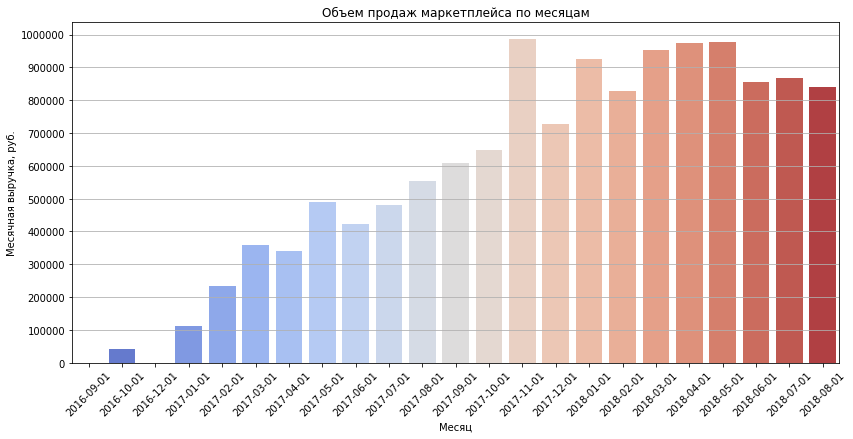

In [109]:
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x = 'order_period', y='monthly_revenue', palette='coolwarm')
plt.yticks(np.linspace(0,1000000,11))
plt.ticklabel_format(style='plain',axis = 'y')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.title('Объем продаж маркетплейса по месяцам')
plt.ylabel('Месячная выручка, руб.')
plt.xlabel('Месяц')
plt.show()

#### 3.2 Объем аудитории, которой продукт доставляет ценность

In [110]:
print(f'Количество пользователей совершивших покупки: {customers_and_orders.customer_unique_id.nunique()}')

Количество пользователей совершивших покупки: 93358


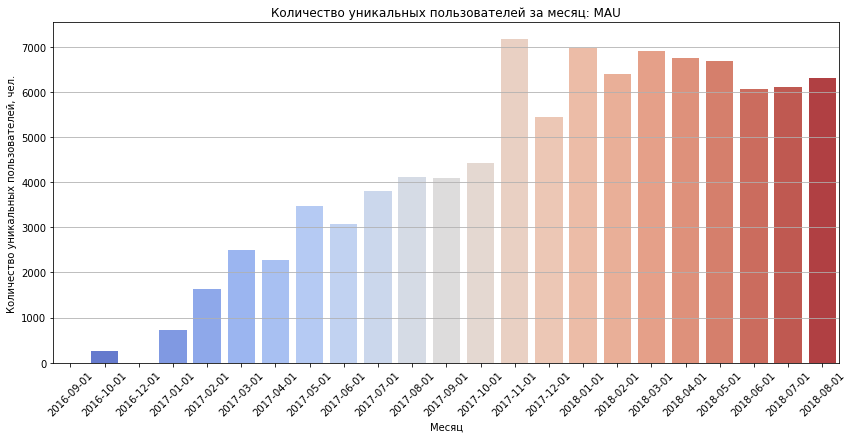

In [111]:
#mau
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x = 'order_period', y='monthly_customers', palette='coolwarm')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.title('Количество уникальных пользователей за месяц: MAU')
plt.ylabel('Количество уникальных пользователей, чел.')
plt.xlabel('Месяц')
plt.show()

Количество уникальных пользователей постепенно увеличивалось, пока не вышло на плато.

#### 3.3 Заинтересованность новых клиентов в продукте

In [112]:
#Доля успешно завершенных заказов
success_orders.order_id.count()/data.order_id.count()

0.8755047778070183

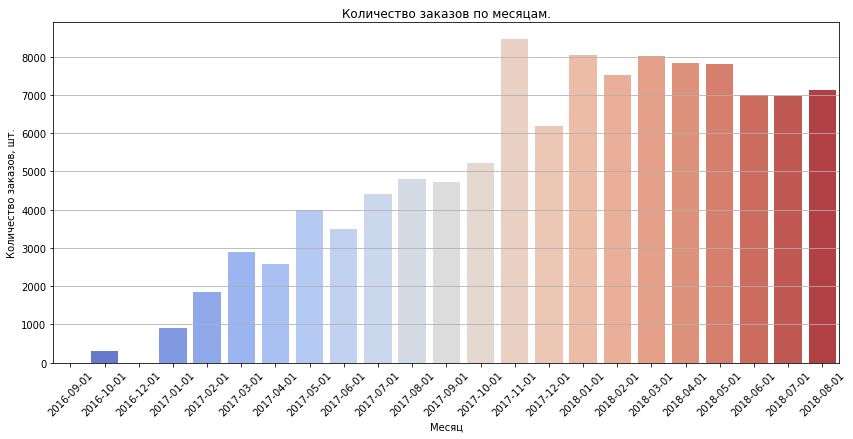

In [113]:
#количество заказов по месяцам
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x = 'order_period', y='count_orders', palette='coolwarm')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.title('Количество заказов по месяцам.')
plt.ylabel('Количество заказов, шт.')
plt.xlabel('Месяц')
plt.show()

Количество заказов постепенно увеличивалось, пока не вышло на плато.

#### 3.4 Вовлеченность клиента в продолжение использования продукта.

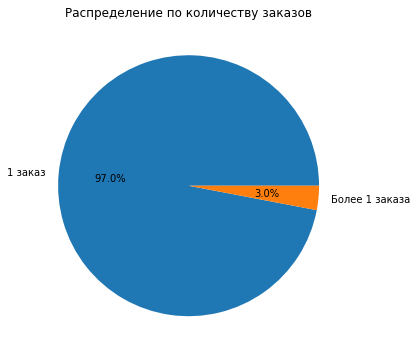

In [114]:
buyers = data.groupby('customer_unique_id', as_index = False)['order_id'].nunique()
one_order = buyers.query('order_id ==1').customer_unique_id.nunique()
more_one_order = buyers.query('order_id > 1').customer_unique_id.nunique()

sizes = [one_order, more_one_order]
labels = ['1 заказ', 'Более 1 заказа']
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по количеству заказов')
plt.show()

Подтверждение низкого retention. Всего 3% пользователей делают более 1 заказа.

#### 3.5 Денежное выражение вовлеченности клиентов.

In [115]:
monthly_sales['ARPPU'] = monthly_sales.monthly_revenue/monthly_sales.monthly_customers

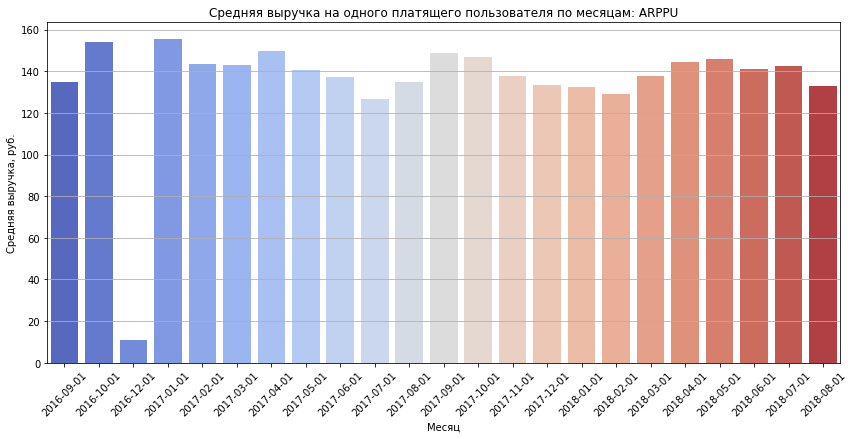

In [116]:
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x = 'order_period', y='ARPPU', palette='coolwarm')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.title('Средняя выручка на одного платящего пользователя по месяцам: ARPPU')
plt.ylabel('Средняя выручка, руб.')
plt.xlabel('Месяц')
plt.show()

Замечена стагнация среднее выручки на одного платящего пользователя.

### 4. Выбор гипотезы с помощью фреймворка ICE

Для перевода метрики в Impact воспользуйтесь следующей шкалой:
- 1:	 0 - 50 
- 2:	51 - 150
- 3:	151 - 350
- 4:	351 - 750
- 5:	751 - 1550
- 6:	1551 - 3150
- 7:	3151 - 6350
- 8:	6351 - 12750 
- 9:	12751 - 25550
- 10:	25551 - 51 150

Данные берутся с июня 2017 года.

In [117]:
#функция перевода метрики импакт в шкалу от 1 до 10
def get_impact(impact):
    if 0 <= impact <= 50:
        return 1
    elif 51 <= impact <= 150:
        return 2
    elif 151 <= impact <= 350:
        return 3
    elif 351 <= impact <= 750:
        return 4
    elif 751 <= impact <= 1550:
        return 5
    elif 1551 <= impact <= 3150:
        return 6
    elif 3151 <= impact <= 6350:
        return 7
    elif 6351 <= impact <= 12750:
        return 8
    elif 12751 <= impact <= 25550:
        return 9
    elif 25551 <= impact <= 51150:
        return 10
    else:
        return "Error"

In [118]:
def get_ice(impact, confidence, ease):
    return get_impact(impact)*confidence*ease

In [119]:
confidence1 = 8
ease1 = 6
confidence2 = 10
ease2 = 4
confidence3 = 5
ease3 = 9

In [120]:
#соединим еще раз все таблицы
since_june_data = orders.query('order_period >"2017-05"').merge(customers, on = 'customer_id', how = 'left')\
                           .merge(order_items, on ='order_id', how='left')
since_june_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,2018-07-24,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,2018-08-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,2017-11-18,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,2018-02-13,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


#### 4.1 Гипотеза №1.

Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

**Impact** - ?

**Confidence** -	8

**Ease** - 6

Рассчитаем impact1.

In [121]:
group_order_status = since_june_data.groupby('order_status', as_index=False).agg(count_orders =('order_id', 'nunique'))
group_order_status

,order_status,count_orders
0,canceled,499
1,created,5
2,delivered,85413
3,invoiced,240
4,processing,202
5,shipped,912
6,unavailable,475


Если избавимся от всех отмен, то получим дополнительно 499 заказов.

In [122]:
impact1 = group_order_status.count_orders[0]

In [123]:
print(f'Значение impact1: {get_impact(impact1)}, значение ICE: {get_ice(impact1, confidence1, ease1)}')

Значение impact1: 4, значение ICE: 192


#### 4.2 Гипотеза №2.

Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. Считаем, что мы таким образом избавимся от всех отмен.

**Impact** - ?

**Confidence** -	10

**Ease** - 4

Рассчитаем impact.

In [124]:
#таблица с количеством заказов и задержкой доставки 
since_june_data['delay_delivered_days'] = (since_june_data.query('order_status == "delivered"').order_delivered_customer_date\
                 - since_june_data.query('order_status == "delivered"').order_estimated_delivery_date).dt.days
since_june_data.query('delay_delivered_days > 0').groupby('delay_delivered_days', as_index = False)\
               .agg(count_orders=('order_id', 'count')).head()

,delay_delivered_days,count_orders
0,1.0,879
1,2.0,561
2,3.0,537
3,4.0,458
4,5.0,471


In [125]:
#время от создания заказа до отгрузки
since_june_data['created_to_shipped_time'] = (since_june_data.order_delivered_carrier_date-\
                                             since_june_data.order_purchase_timestamp).dt.days

#таблица, где указана выручка, количество заказов, в зависимости от количества дней от создания заказа до его отгрузки
group_delay_shipped = since_june_data.query('order_status=="delivered" & created_to_shipped_time >0')\
               .groupby('created_to_shipped_time', as_index = False).agg(revenue=('price', 'sum'),
                                                                         count_orders=('order_id', 'nunique'))\
               .assign(revenue_perc = lambda x: x.revenue/x.revenue.sum())\
               .assign(orders_perc = lambda x: x.count_orders/x.count_orders.sum())\
               .query('revenue_perc > 0.01 & orders_perc > 0.01')
group_delay_shipped

,created_to_shipped_time,revenue,count_orders,revenue_perc,orders_perc
0,1.0,2763345.19,21678,0.288693,0.313974
1,2.0,1995274.18,14664,0.208451,0.212386
2,3.0,1483281.98,10825,0.154962,0.156784
3,4.0,980930.25,7095,0.102480,0.102761
4,5.0,657696.17,4799,0.068711,0.069506
5,6.0,463162.74,3200,0.048388,0.046347
6,7.0,295391.93,1809,0.030860,0.026201
7,8.0,168624.82,1062,0.017617,0.015381
8,9.0,113104.18,747,0.011816,0.010819


In [126]:
since_june_data.query('created_to_shipped_time>0')['created_to_shipped_time'].describe()

count    80128.000000
mean         3.406088
std          3.589319
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        125.000000
Name: created_to_shipped_time, dtype: float64

In [127]:
#retention по опоздавшим заказам
conversion_delay_group = since_june_data.query('delay_delivered_days >= 0 and order_status=="delivered"')\
                                                  .groupby('customer_unique_id', as_index= False)\
                                                  .agg(count_orders=('order_id', 'nunique'))                                               

In [128]:
#конверсия в повторный заказ от общего количества опоздавших заказов
conversion_delay = round(conversion_delay_group.count_orders.value_counts()[1:].sum()
                        /conversion_delay_group.count_orders.value_counts()[:1].sum(),4)
conversion_delay

0.0067

Медианное время от создания заказа до отгрузки составляет 2 дня.

In [129]:
#конверсия в повторный заказ с отгрузкой более 8 дней
conversion_delay_group2 = since_june_data.query('delay_delivered_days >= 0 and order_status=="delivered" \
                                         and created_to_shipped_time >2')\
                                                  .groupby('customer_unique_id', as_index= False)\
                                                  .agg(count_orders=('order_id', 'nunique'))\
                                                    .sort_values(by='count_orders')

In [130]:
conversion_delay2 = round(conversion_delay_group2.count_orders.value_counts()[1:].sum()/
                          conversion_delay_group2.count_orders.value_counts()[:1].sum(),4)
conversion_delay2

0.0056

In [131]:
#количество отмененных заказов при долгом времени сборки(8 и более дней)
canceled_delay_orders = since_june_data.query('order_status=="canceled" and created_to_shipped_time >2').order_id.count()
canceled_delay_orders

21

In [132]:
#количество заказов, которые можно было совершить 
#количество заказов = отмененные заказы(отгрузка 8 дней и более) + упущенные повторные заказы
#упущенные повторные заказы = заказы с отгрузкой более 8 дней * разницу конверсии 
count_orders_delay = round(since_june_data.query('delay_delivered_days >= 0 and order_status=="delivered" \
                                         and created_to_shipped_time >2')\
                                    .order_id.count()*(conversion_delay-conversion_delay2) + canceled_delay_orders,0)
count_orders_delay

26.0

In [133]:
impact2 = count_orders_delay
print(f'Значение impact2: {get_impact(impact2)}, значение ICE: {get_ice(impact2, confidence2, ease2)}')

Значение impact2: 1, значение ICE: 40


Значение impact могло быть и больше, если взять количество дней на отгрузку меньше.

#### 4.3 Гипотеза №3.

Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

**Impact** - ?

**Confidence** -	5

**Ease** - 9

Рассчитаем impact.

In [134]:
#время от создания заказа до подтверждения оплаты
since_june_data['approved_time'] = since_june_data.order_approved_at - since_june_data.order_purchase_timestamp
since_june_data['approved_time'].describe()

count                       100038
mean     0 days 10:37:06.064565465
std      0 days 21:10:12.582932658
min                0 days 00:05:23
25%                0 days 00:13:32
50%                0 days 00:22:09
75%                0 days 15:24:28
max               32 days 12:51:18
Name: approved_time, dtype: object

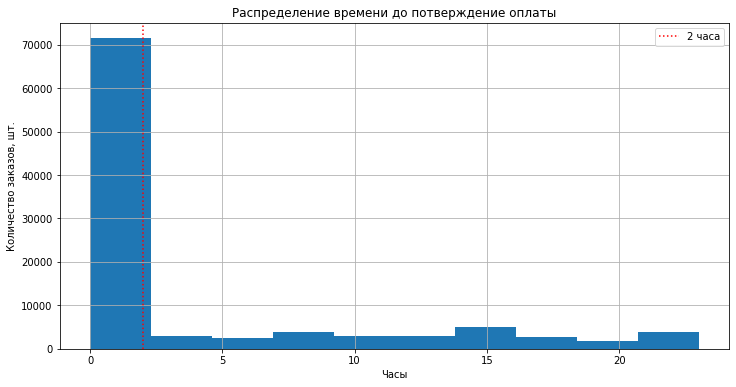

In [135]:
#гистограмма распределение времени клиентов до подвтерждения оплаты
plt.figure(figsize = (12,6))
plt.hist(since_june_data['approved_time'].dt.components['hours'], bins = 10)
plt.axvline(x = 2, color = 'r', linestyle='dotted', label = '2 часа')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'best')
plt.title('Распределение времени до потверждение оплаты')
plt.xlabel('Часы')
plt.ylabel('Количество заказов, шт.')
plt.grid()
plt.show()

Считаем, что быстрое подтверждение на оплату 2 часа. Остальное будет долгим.

In [136]:
#количество пользователей, которые отменили заказ при подтверждении оплаты дольше 2 часов
canceled_approved_orders = since_june_data.query('approved_time > "02:00:00" and  order_status =="canceled"').order_id.nunique()
canceled_approved_orders

111

In [137]:
fast_approve = since_june_data.query('approved_time <= "02:00:00" and  order_status =="delivered"')
long_approve = since_june_data.query('approved_time > "02:00:00" and  order_status =="delivered"')

In [138]:
#количество заказов пользователей совершивших более 1 покупки при быстром подтверждении оплаты
customers_fast_approve = fast_approve.groupby('customer_unique_id', as_index= False)\
                                                  .agg(count_orders=('order_id', 'nunique'))
customers_fast_approve.query('count_orders > 1').count_orders.sum()                                                 

2914

In [139]:
#количество заказов пользователей совершивших более 1 покупки при долгом подтверждении оплаты
customers_long_approve = long_approve.groupby('customer_unique_id', as_index= False)\
                                                  .agg(count_orders=('order_id', 'nunique'))
customers_long_approve.query('count_orders > 1').count_orders.sum()                                               

1153

In [140]:
conversion_fast_approve = customers_fast_approve.query('count_orders > 1').count_orders.sum()/\
                                customers_fast_approve.count_orders.sum()
conversion_fast_approve

0.05107800175284838

In [141]:
conversion_long_approve = customers_long_approve.query('count_orders > 1').count_orders.sum()/\
                                customers_long_approve.count_orders.sum()
conversion_long_approve

0.04065155307971653

In [142]:
#расчет возможных потерянных заказов = количество отмененных заказов + 
#+возможное количество повторных заказов при конверсии быстрого подтверждения оплаты - количество заказов при конверсии долгого 
#подтверждения
impact3 = round(canceled_approved_orders + (customers_long_approve.count_orders.sum()*conversion_fast_approve\
                                      - customers_long_approve.query('count_orders > 1').count_orders.sum()), 0)
print(f'Значение impact2: {get_impact(impact3)}, значение ICE: {get_ice(impact3, confidence3, ease3)}')

Значение impact2: 4, значение ICE: 180


Гипотеза 1 -  значение ICE: 192.

Гипотеза 2 - значение ICE: 40. 

Гипотеза 3 -  значение ICE: 180.

Гипотезу 2 однозначно не рассмаотриваем. Значения 1 и 3 гипотезы близки по значению ICE, но первая имеет чуть большее значение. Сложность на исправления бага больше, поэтому нужно понять, сколько времени нужно будет выделить разработчикам для этого исправления, в отличие от создания нового способа оплаты. 

Для улучшения PMF(product/market fit) стоит приглядется на 3-ю гипотезу, так как она напрямую связана с retention наших пользователей. 


### 5.  Метрики, на которые гипотеза должна повлиять

**Гипотеза 1**

Целевая метрика - выручка.

Прокси метрика - количество заказов.

Guardrails - Удержание пользователей.

**Гипотеза 3**

Целевая метрика - retention.

Прокси метрика - количество клиентов вернувшиеся в продукт.

Guardrails - выручка.

### 6. Общие выводы и комментарии.

**Проблема продукта**

Очень низкий уровень метрики удержания клиентов(retention) и нахождение выручки на одном и том же месте.

**Выводы**
1. Проведя когортный анализ был сделан вывод, что retention пользователей находится на очень низком уровне, не превышая 1%. 

2. Product/market fit отсутствует, но ежемесячный приток новых пользователей есть.

3. До 2017 года был замечен рост объема продаж по месяцам, количество уникальных пользователей за месяц(MAU), количество заказов по месяцам. Далее эти метрики вышли на плато. Средняя выручка на одного платящего пользователя(ARPPU) находится на одном и том же уровне ~140-150 руб. Всего 3% пользователей делают больше 1 заказа.

4. Проведен анализ предложенных гипотез: первым делом стоит починить баг, а далее ввести новый способ оплаты для клиентов.

5. Целевая метрика для первой гипотезы - выручка, прокси метрика - количество заказов, guardrails - удержание пользователей;
   Целевая метрика для второй гипотезы - retention, прокси метрика - количество клиентов вернувшиеся в продукт, guardrails - выручка;
   

**Рекомендации**

В продукте отличным образом работает привлечение клиентов, но обязательно нужно что-то делать с их удержанием. После теста предложенных гипотез, стоит сформулировать еще несколько других. Обязательно нужно провести опрос пользователей и узнать слабые и сильные стороны продукта, а также посмотреть на конкурентов.  